# <center> Deep Learning Project</center>
## <center>Spooky Authors Identification</center>
### <center>Functional Architecture (Tfi-df + Historical Embedding + Handcrafted Features)</center>
#### <center>Score on Kaggle: 0.35 log loss</center>


---


*   Eduardo Brendao (MLDM)
*   Mohammad Poul Doust (MLDM)



# Preprocessing

In [0]:
# Preprocessing
def add_puctuation_and_n_grams(df, n_gram_max=3):
    def add_ngram(q, n_gram_max):
            ngrams = []
            for n in range(2, n_gram_max+1):
                for w_index in range(len(q)-n+1):
                    ngrams.append('--'.join(q[w_index:w_index+n]))
            return q + ngrams
    
    def punctuation_to_words(text):
      text = text.replace("' ", " ' ")
      signs = set(',.:;"?!')
      prods = set(text) & signs
      if not prods:
          return text

      for sign in prods:
          text = text.replace(sign, ' {} '.format(sign) )
      return text

    docs = []

    if isinstance(df, pd.DataFrame):
      for doc in df.text:
        doc = punctuation_to_words(doc).split()
        docs.append(' '.join(add_ngram(doc, n_gram_max)))
    else:
      for doc in df:
        doc = punctuation_to_words(doc).split()
        docs.append(' '.join(add_ngram(doc, n_gram_max)))
   
    return docs

In [0]:
#imports
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, LatentDirichletAllocation
from math import floor
import pickle
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

#keras
from keras.initializers import Constant
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM, Dropout,BatchNormalization, Input, Conv1D, MaxPooling1D, Flatten
import keras
from keras.layers import concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import warnings

nltk.download('stopwords')
warnings.filterwarnings('ignore')
stop_words = set(stopwords.words('english')) 
nltk.download('averaged_perceptron_tagger')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# HistWords scikit learn estimator

In [0]:
# An estimator for use with ELI5 plus a bonus function because that's how I got it to work

from sklearn.base import BaseEstimator, TransformerMixin

class HistoricalClassifier(BaseEstimator, TransformerMixin):
  '''Wrapper class for keras text classification models that takes raw text as input.'''
  
  def __init__(self, input1_dim, input2_dim,  min_count =50, input_length=1000, n_classes=3, epochs=17, batch_size=128, number_of_n_grams =4, embedding_dim =300, weights = None):
    self.emb_dim = embedding_dim
    self.input1_dim = input1_dim
    self.input2_dim = input2_dim
    self.input_length = input_length
    self.n_classes = n_classes
    self.epochs = epochs
    self.bs = batch_size
    self.min_count = min_count
    self.model = self._get_model(weights)
    self.number_of_n_grams = number_of_n_grams
    self.tokenizer = None
    return self.model.summary()
    
  # def _get_model(self, _weights = None):
  #   """This is fast text, as per https://arxiv.org/abs/1607.01759"""
  #   model = Sequential()
  #   if _weights is not None:
  #     model.add(Embedding(input_dim = self.input_dim,output_dim=self.emb_dim, weights = [_weights], trainable = True))
  #     # model.add(Embedding(input_dim = self.input_dim,output_dim=self.emb_dim, embeddings_initializer=Constant(weights)))
  #     print('weights initialized')
  #   else:
  #     model.add(Embedding(input_dim = self.input_dim,output_dim=self.emb_dim))
  #   model.add(GlobalAveragePooling1D())
  #   model.add(Dense(self.n_classes, activation='softmax'))

  #   model.compile(loss='categorical_crossentropy',
  #                 optimizer="adam",
  #                 metrics=['accuracy']) 
  #   return model



  # def _get_model(self, _weights = None):
  #   tfidf_input = keras.Input(shape=(self.input1_dim,))
  #   embed_input = keras.Input(shape=(self.input2_dim,))
  #   print('self.input2_dim: ', self.input2_dim)
  #   print('weight.shape: ', _weights.shape)

  #   x = keras.layers.Dense(10, activation='relu')(tfidf_input)
  #   x = Model(inputs=tfidf_input, outputs=x)

  #   # y = keras.layers.Embedding(input_dim = self.input_dim,output_dim=self.emb_dim, weights = [_weights], trainable = True)(embed_input)
  #   # # embed_dense1 = keras.layers.Dense(30, activation='relu')(embed_1)
  #   # y = Model(inputs=embed_input, outputs=y)

  #   y = keras.layers.Embedding(input_dim = self.input2_dim,output_dim=self.emb_dim, weights = [_weights], trainable = True)(embed_input)
  #   y = keras.layers.GlobalAveragePooling1D()(y)
  #   y = Model(inputs=embed_input, outputs=y)

  #   combined = concatenate([x.output, y.output])
  #   z = keras.layers.Dense(self.n_classes, activation='softmax')(combined)

  #   model = keras.models.Model(inputs=[x.input, y.input], outputs=z)
  #   # model = keras.models.Model(inputs=tfidf_input,outputs=output)

  #   print('self.input2_dim: ', self.input2_dim)
  #   print('weight.shape: ', _weights.shape)

  #   model.compile(loss='categorical_crossentropy',
  #                 optimizer="adam",
  #                 metrics=['accuracy']) 
  #   return model

  def _get_model(self, _weights = None):
    tfidf_input = keras.Input(shape=(self.input1_dim,))
    embed_input = keras.Input(shape=(self.input2_dim,))
    features_input = keras.Input(shape=(12,))

    # print('self.input2_dim: ', self.input2_dim)
    # print('weight.shape: ', _weights.shape)

    x = keras.layers.Dense(10, activation='relu')(tfidf_input)
    x = Model(inputs=tfidf_input, outputs=x)

    y = keras.layers.Embedding(input_dim = self.input2_dim,output_dim=self.emb_dim, weights = [_weights], trainable = True)(embed_input)
    y = keras.layers.GlobalAveragePooling1D()(y)
    # y = keras.layers.Flatten()(y)
    # y = keras.layers.Dense(64)(y)
    y = Model(inputs=embed_input, outputs=y)

    f = keras.layers.Dense(10, activation='relu')(features_input)
    f = Model(inputs=features_input, outputs=f)
    # f = Model(inputs=features_input, outputs=features_input)

    combined = concatenate([x.output, y.output, f.output])
    z = keras.layers.Dense(self.n_classes, activation='softmax')(combined)

    model = keras.models.Model(inputs=[x.input, y.input, f.input], outputs=z)
    # model = keras.models.Model(inputs=tfidf_input,outputs=output)

    # print('self.input2_dim: ', self.input2_dim)
    # print('weight.shape: ', _weights.shape)

    opt = keras.optimizers.Adam()

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy']) 
    return model


  def _get_tokenizer(self, X):
    texts = self._preprocess(X)
    tokenizer = Tokenizer(lower=True, filters='')
    tokenizer.fit_on_texts(texts)
    return tokenizer


  
  def _get_sequences(self, X):
    """Change lower=False not to match case"""
    texts = self._preprocess(X)
    tokenizer = Tokenizer(lower=True, filters='')
    tokenizer.fit_on_texts(texts)
    num_words = sum([1 for _, v in tokenizer.word_counts.items() if v >= self.min_count])
    
    # tokenizer = Tokenizer(lower=False, filters='')
    tokenizer = Tokenizer(num_words=num_words, lower=True, filters='')
    tokenizer.fit_on_texts(texts)
    texts = tokenizer.texts_to_sequences(texts)
    texts = pad_sequences(sequences = texts, maxlen=self.input_length)
    self.tokenizer =tokenizer 
    return texts
  
  def _preprocess(self, texts):
    return add_puctuation_and_n_grams(texts)
  
  def fit(self, X, y):
    '''Fit the vocabulary and the model.
       :params: X: list of texts. y: labels.
    '''
    docs = self._get_sequences(X)
    x_train, x_test, y_train, y_test = train_test_split(docs, y, test_size=0.1)

    self.model.fit(x_train, y_train,
                 batch_size=self.bs,
                 validation_data=(x_test, y_test),
                 epochs=self.epochs,
                 callbacks=[EarlyStopping(patience=1, monitor='val_loss')])



  # def fit_both(self, X, y):
  #   '''Fit the vocabulary and the model.
  #      :params: X: list of texts. y: labels.
  #   '''
  #   tfidf = TfidfVectorizer(max_features = 10000)
  #   # X_tfidf = tfidf.fit_transform(X['text'])

  #   x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
  #   x_train_tfidf = tfidf.fit_transform(x_train)
  #   x_test_tfidf =  tfidf.transform(x_test)

  #   x_train_text = self._get_sequences(x_train)
  #   x_test_text = self._get_sequences(x_test)
  #   print('x_train_text.shape: ', x_train_text.shape)
  #   print('x_test_text.shape: ', x_test_text.shape)

  #   self.model.fit([x_train_tfidf, x_train_text], y_train,
  #                batch_size=self.bs,
  #                validation_data=([x_test_tfidf, x_test_text], y_test),
  #                epochs=self.epochs,
  #                callbacks=[EarlyStopping(patience=3, monitor='val_loss')])


  def fit_both(self, X, y):
    '''Fit the vocabulary and the model.
       :params: X: list of texts. y: labels.
    '''
    self.tfidf = TfidfVectorizer(max_features = self.input1_dim)

    # X_tfidf = tfidf.fit_transform(X['text'])

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    x_train_tfidf = self.tfidf.fit_transform(x_train.text)
    x_test_tfidf =  self.tfidf.transform(x_test.text)

    x_train_text = self._get_sequences(x_train.text)
    x_test_text = self._get_sequences(x_test.text)

    x_train_features = x_train.iloc[:,3:]
    x_test_features = x_test.iloc[:,3:]

    print('x_train_tfidf.shape: ', x_train_tfidf.shape)
    print('x_train_text.shape: ', x_train_text.shape)
    print('x_train_features.shape: ', x_train_features.shape)

    self.model.fit([x_train_tfidf, x_train_text, x_train_features], y_train,
                 batch_size=self.bs,
                 validation_data=([x_test_tfidf, x_test_text, x_test_features], y_test),
                 epochs=self.epochs,
                 callbacks=[EarlyStopping(patience=0, monitor='val_loss')])




  def fit_both_submit(self, X, y):
    '''Fit the vocabulary and the model.
       :params: X: list of texts. y: labels.
    '''
    x_train_tfidf = self.tfidf.fit_transform(X.text)
    x_train_text = self._get_sequences(X.text)
    x_train_features = X.iloc[:,3:]

    self.model.fit([x_train_tfidf, x_train_text, x_train_features], y,
                 batch_size=self.bs,
                 epochs=self.epochs,
                 callbacks=[EarlyStopping(patience=1, monitor='val_loss')])



  def predict_proba_both(self, X, y= None):
    # tfidf = TfidfVectorizer(max_features = self.input1_dim)


    x_train_tfidf = self.tfidf.transform(X.text)
    x_train_text = self._get_sequences(X.text)
    x_train_features = X.iloc[:,3:]

    print('x_train_tfidf.shape: ', x_train_tfidf.shape)
    print('x_train_text.shape: ', x_train_text.shape)
    print('x_train_features.shape: ', x_train_features.shape)

    print('self.input1_dim.shape: ', self.input1_dim)


    return self.model.predict([x_train_tfidf, x_train_text, x_train_features])

  def predict_proba(self, X, y=None):
    seqs = self._get_sequences(self._preprocess(X))
    return self.model.predict(seqs)
  
  def predict(self, X, y=None):
    return np.argmax(self.predict_proba(X), axis=1)
  
  def score(self, X, y):
    y_pred = self.predict(X)
    return accuracy_score(np.argmax(y, axis=1), y_pred)

def get_input_dimension(X, min_count=10, maxlen=512):
  """ Before creating a model, input dimension changes cuz we remove low freq words (lower than min_count)"""
  docs = add_puctuation_and_n_grams(X)

  tokenizer = Tokenizer(lower=True, filters='')
  tokenizer.fit_on_texts(docs)
  num_words = sum([1 for _, v in tokenizer.word_counts.items() if v >= min_count])

  tokenizer = Tokenizer(num_words=num_words, lower=True, filters='')
  tokenizer.fit_on_texts(docs)
  docs = tokenizer.texts_to_sequences(docs)
  
  docs = pad_sequences(sequences=docs, maxlen=maxlen)

  print('docs: ', docs)
  return np.max(docs) + 1


# Get Data
... and split to debug with ELI5. Submission would use the entire training set.

## Downloading

In [0]:
# get dataset from Kaggle -- feel free to use my API key :)
import os
os.environ['KAGGLE_USERNAME'] = "extremelydifficult" # username from the json file
os.environ['KAGGLE_KEY'] = "238120927f9705524c124fcbdb19b699" # key from the json file
!kaggle competitions download -c spooky-author-identification
!unzip train.zip
!unzip test.zip

train.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  test.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Processing

In [0]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# get data from dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# sample = pd.read_csv('sample_submission.csv')
# Keras likes categorical
a2c = {'EAP': 0, 'HPL' : 1, 'MWS' : 2}
c2a = {value:key for key, value in a2c.items()}



authors = np.array([a2c[a] for a in train.author])
authors = to_categorical(authors)

# split data (JUST FOR DEBUGGING WITH ELI5 -- submission would use all training data)
text_train, text_valid, authors_train, authors_valid = train_test_split(train.text.values, authors, 
                                                   stratify=authors, 
                                                   test_size=0.1, shuffle=True)

# because it's easier than changing the loop below
x_train = pd.DataFrame(text_train, columns = ["text"])
x_test = pd.DataFrame(text_valid, columns = ["text"])
train = train.drop('author', 1)

## Extra Features

In [0]:
# def char_count(row):
#     """function to return number of chracters """
#     return len(row['text'])

def unique_word_fraction(row):
    """function to calculate the fraction of unique words on total words of the text"""
    text = row
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    unique_count = list(set(text_splited)).__len__()
    return (unique_count/word_count)

def punctuations_fraction(row):
    """functiopn to claculate the fraction of punctuations over total number of characters for a given text """
    text = row
    char_count = len(text)
    punctuation_count = len([c for c in text if c in string.punctuation])
    return (punctuation_count/char_count)


def fraction_noun(row):
    """function to give us fraction of noun over total words """
    text = row
    # text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    pos_list = nltk.pos_tag(text_splited)
    noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])
    return (noun_count/word_count)

def fraction_adj(row):
    """function to give us fraction of adjectives over total words in given text"""
    text = row
    # text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    pos_list = nltk.pos_tag(text_splited)
    adj_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])
    return (adj_count/word_count)

def fraction_verbs(row):
    """function to give us fraction of verbs over total words in given text"""
    text = row
    # text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    pos_list = nltk.pos_tag(text_splited)
    verbs_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
    return (verbs_count/word_count)



def fraction_adverbs(row):
    """function to give us fraction of verbs over total words in given text"""
    text = row
    # text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    pos_list = nltk.pos_tag(text_splited)
    verbs_count = len([w for w in pos_list if w[1] in ('RB','RBR','RBS', 'WRB')])
    return (verbs_count/word_count)

def special(row):
    """function to give us fraction of verbs over total words in given text"""
    text = row
    # text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    pos_list = nltk.pos_tag(text_splited)
    verbs_count = len([w for w in pos_list if w[1] in ('PDT','POS')])
    # verbs_count = len([w for w in pos_list if w[1] in ('PDT','POS	','PRP$', 'UH')])
    return (verbs_count/word_count)

In [0]:
## Number of words in the text ##
train["num_words"] = train["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
# train["num_unique_words"] = train["text"].apply(lambda x: len(set(str(x).split())))
train['unique_word_fraction'] = train['text'].apply(lambda row: unique_word_fraction(row))

## Number of characters in the text ##
train["num_chars"] = train["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train["num_stopwords"] = train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

## Number of punctuations in the text ##
# train["num_punctuations"] =train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
train['punctuations_fraction'] = train['text'].apply(lambda row: punctuations_fraction(row))

## Number of title case words in the text ##
train["num_words_upper"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train["num_words_title"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train["mean_word_len"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# train['char_count'] = train["text"].apply(lambda row: char_count(row))
train['fraction_noun'] = train['text'].apply(lambda row: fraction_noun(row))
train['fraction_adj'] = train['text'].apply(lambda row: fraction_adj(row))
train['fraction_verbs'] = train['text'].apply(lambda row: fraction_verbs(row))
train['fraction_adverbs'] = train['text'].apply(lambda row: fraction_verbs(row))
train['special'] = train['text'].apply(lambda row: fraction_verbs(row))



In [0]:
## Number of words in the text ##
test["num_words"] = test["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
# train["num_unique_words"] = train["text"].apply(lambda x: len(set(str(x).split())))
test['unique_word_fraction'] = test['text'].apply(lambda row: unique_word_fraction(row))

## Number of characters in the text ##
test["num_chars"] = test["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
test["num_stopwords"] = test["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

## Number of punctuations in the text ##
# train["num_punctuations"] =train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test['punctuations_fraction'] = test['text'].apply(lambda row: punctuations_fraction(row))

## Number of title case words in the text ##
test["num_words_upper"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
test["num_words_title"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
test["mean_word_len"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# train['char_count'] = train["text"].apply(lambda row: char_count(row))
test['fraction_noun'] = test['text'].apply(lambda row: fraction_noun(row))
test['fraction_adj'] = test['text'].apply(lambda row: fraction_adj(row))
test['fraction_verbs'] = test['text'].apply(lambda row: fraction_verbs(row))
test['fraction_adverbs'] = test['text'].apply(lambda row: fraction_verbs(row))
test['special'] = test['text'].apply(lambda row: fraction_verbs(row))



# Historical Embeddings

## Downloading

In [0]:
#historical all english
!wget 'http://snap.stanford.edu/historical_embeddings/eng-all_sgns.zip' -O "all_english.zip" 

--2020-01-05 13:14:57--  http://snap.stanford.edu/historical_embeddings/eng-all_sgns.zip
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1686718098 (1.6G) [application/zip]
Saving to: ‘all_english.zip’

all_english.zip       5%[>                   ]  89.24M  21.6MB/s    eta 2m 10s ^C


In [0]:
!unzip all_english.zip -d all_english

Archive:  all_english.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of all_english.zip or
        all_english.zip.zip, and cannot find all_english.zip.ZIP, period.


## Processing

In [0]:
embeddings_index = {}
coefs = np.load('/content/all_english/sgns/1800-w.npy')
words = pickle.load( open( "/content/all_english/sgns/1800-vocab.pkl", "rb" ) )
embedding_index = {words[i] : coefs[i] for i in range(len(words))}

In [0]:
EMBEDDING_DIM = 150
# in_dim = get_input_dimension(train.text)

In [0]:
in_dim = 500

In [0]:
# word_index = text_model._get_tokenizer(x_train).word_index
texts = add_puctuation_and_n_grams(train.text)
tokenizer = Tokenizer(lower=True, filters='')
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

MAX_NUM_WORDS = 200000
num_words = in_dim
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(500, 150)

# Model

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 17546)        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 500, 150)     75000       input_14[0][0]                   
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 12)           0                                            
___________________________________________________________________________________________

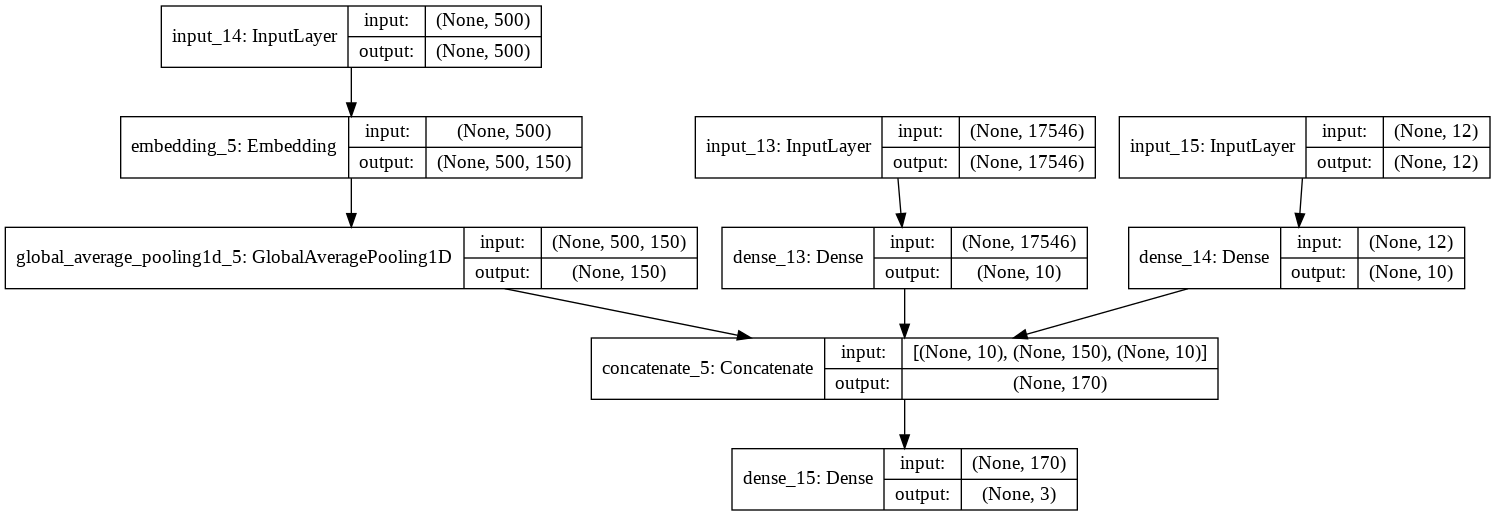

In [0]:
# text_model = HistoricalClassifier(input_dim = in_dim, n_classes=3, weights= embedding_matrix, embedding_dim=300)
text_model = HistoricalClassifier(input1_dim = 17546, input2_dim = embedding_matrix.shape[0], input_length = in_dim, n_classes=3, weights= embedding_matrix, embedding_dim=EMBEDDING_DIM)
plot_model(text_model.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
text_model.fit_both(train, authors)

# text_model.fit_tf(x_train, authors_train)

# text_model.fit(x_train, authors_train)

x_train_tfidf.shape:  (17621, 17546)
x_train_text.shape:  (17621, 500)
x_train_features.shape:  (17621, 12)
Train on 17621 samples, validate on 1958 samples
Epoch 1/17
17621/17621 [==============================] - 3s 178us/step - loss: 2.2835 - acc: 0.3582 - val_loss: 1.1256 - val_acc: 0.3943
Epoch 2/17
17621/17621 [==============================] - 3s 145us/step - loss: 1.0084 - acc: 0.5184 - val_loss: 0.9251 - val_acc: 0.5766
Epoch 3/17
17621/17621 [==============================] - 3s 143us/step - loss: 0.7661 - acc: 0.7952 - val_loss: 0.6899 - val_acc: 0.7962
Epoch 4/17
17621/17621 [==============================] - 3s 143us/step - loss: 0.5303 - acc: 0.8812 - val_loss: 0.5287 - val_acc: 0.8519
Epoch 5/17
17621/17621 [==============================] - 2s 140us/step - loss: 0.3900 - acc: 0.9080 - val_loss: 0.4535 - val_acc: 0.8596
Epoch 6/17
17621/17621 [==============================] - 3s 142us/step - loss: 0.3071 - acc: 0.9262 - val_loss: 0.4132 - val_acc: 0.8647
Epoch 7/17
1762

In [0]:
weightspath= 'weights-spooky.h5'
modelpath= 'model-spooky.h5'
text_model.model.save_weights(weightspath)
text_model.model.save(modelpath)

In [0]:
preds = text_model.predict_proba_both(test)
result = pd.DataFrame(preds, columns=['EAP','HPL','MWS'])
result.insert(0, 'id', test['id'])
result.to_csv('submission.csv', index=False, float_format='%.20f')


x_train_tfidf.shape:  (8392, 17546)
x_train_text.shape:  (8392, 500)
x_train_features.shape:  (8392, 12)
self.input1_dim.shape:  17546


**private score : 0.35**